# Fake news detection

In [1]:
import os
import numpy as np
import pandas as pd

## Read datasets

In [2]:
data_path = os.path.join(os.path.dirname(os.getcwd()), "data")

df_data = pd.read_csv(f"{data_path}/fake_news/train.csv")
df_data.shape

(20800, 5)

In [3]:
df_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Data cleaning and preparation

In [4]:
df_data.drop(["id"], axis=1, inplace=True)
df_data.head()

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
df_data = df_data[df_data['text'].notna()]
df_data = df_data[df_data['title'].notna()]
df_data = df_data.fillna('null')

In [6]:
df_data.shape

(20203, 4)

In [7]:
# Removeing punctuations
import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    
    return clean_str

df_data['text'] = df_data['text'].apply(punctuation_removal)
df_data['title'] = df_data['title'].apply(punctuation_removal)
df_data.head()

,title,author,text,label
0,House Dem Aide We Didn’t Even See Comey’s Lett...,Darrell Lucus,House Dem Aide We Didn’t Even See Comey’s Lett...,1
1,FLYNN Hillary Clinton Big Woman on Campus Bre...,Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,Why the Truth Might Get You Fired October 29 2...,1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [8]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

df_data['text'] = df_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_data['title'] = df_data['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /home/apollo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df_data.head()

,title,author,text,label
0,House Dem Aide We Didn’t Even See Comey’s Lett...,Darrell Lucus,House Dem Aide We Didn’t Even See Comey’s Lett...,1
1,FLYNN Hillary Clinton Big Woman Campus Breitbart,Daniel J. Flynn,Ever get feeling life circles roundabout rathe...,0
2,Why Truth Might Get You Fired,Consortiumnews.com,Why Truth Might Get You Fired October 29 2016 ...,1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed fictional unpublished sto...,Howard Portnoy,Print An Iranian woman sentenced six years pri...,1


## Modeling

In [10]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [11]:
labels = df_data['label'].values.tolist()
df_data.drop(["label"], axis=1, inplace=True)
data = df_data.values.tolist()

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

# Split the data
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=42)

### Logistic regression

In [13]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer(analyzer=lambda x: x)),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
lgr_model = pipe.fit(X_train, y_train)

y_pred = lgr_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.88      1.00      0.93      2089
        Fake       1.00      0.85      0.92      1952

    accuracy                           0.93      4041
   macro avg       0.94      0.92      0.92      4041
weighted avg       0.93      0.93      0.92      4041



Confusion matrix, without normalization


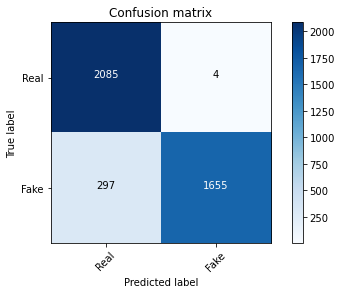

In [14]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Real', 'Fake'])

### Naive Bayes

In [15]:
from sklearn.naive_bayes import MultinomialNB

pipe = Pipeline([('vect', CountVectorizer(analyzer=lambda x: x)),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

# Fitting the model
nb_model = pipe.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.91      1.00      0.95      2089
        Fake       1.00      0.89      0.94      1952

    accuracy                           0.95      4041
   macro avg       0.95      0.94      0.95      4041
weighted avg       0.95      0.95      0.95      4041



Confusion matrix, without normalization


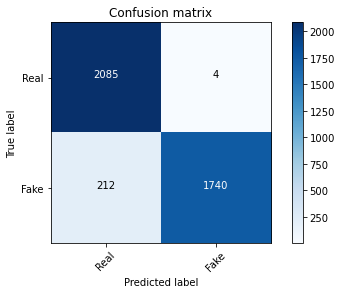

In [16]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Real', 'Fake'])

### Decision Tree Classifier

In [17]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer(analyzer=lambda x: x)),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth=20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
dt_model = pipe.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.59      1.00      0.74      2089
        Fake       0.99      0.25      0.40      1952

    accuracy                           0.64      4041
   macro avg       0.79      0.63      0.57      4041
weighted avg       0.78      0.64      0.58      4041



Confusion matrix, without normalization


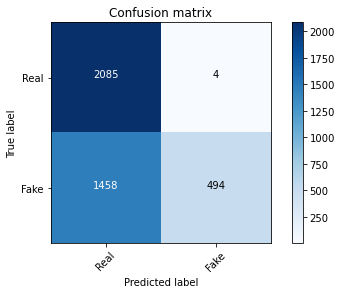

In [18]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Real', 'Fake'])

### Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer(analyzer=lambda x: x)),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

rfc_model = pipe.fit(X_train, y_train)

y_pred = rfc_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.85      1.00      0.92      2089
        Fake       1.00      0.81      0.90      1952

    accuracy                           0.91      4041
   macro avg       0.92      0.91      0.91      4041
weighted avg       0.92      0.91      0.91      4041



Confusion matrix, without normalization


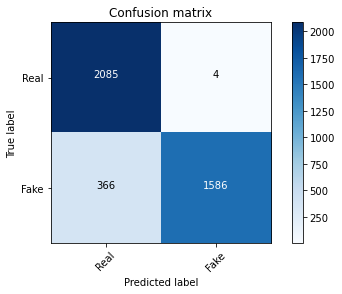

In [20]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Real', 'Fake'])

### Adaboost Classifier

In [21]:
from sklearn.ensemble import AdaBoostClassifier

pipe = Pipeline([('vect', CountVectorizer(analyzer=lambda x: x)),
                 ('tfidf', TfidfTransformer()),
                 ('model', AdaBoostClassifier())])

ada_model = pipe.fit(X_train, y_train)

y_pred = ada_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.65      1.00      0.78      2089
        Fake       1.00      0.42      0.59      1952

    accuracy                           0.72      4041
   macro avg       0.82      0.71      0.69      4041
weighted avg       0.82      0.72      0.69      4041



Confusion matrix, without normalization


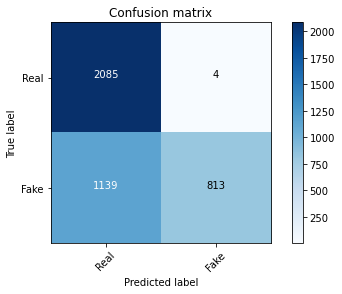

In [22]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Real', 'Fake'])

### XGBoost Classifier

In [23]:
from xgboost import XGBClassifier

pipe = Pipeline([('vect', CountVectorizer(analyzer=lambda x: x)),
                 ('tfidf', TfidfTransformer()),
                 ('model', XGBClassifier(use_label_encoder=False))])

xgb_model = pipe.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

[03:44:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

        Real       0.59      1.00      0.74      2089
        Fake       1.00      0.26      0.41      1952

    accuracy                           0.64      4041
   macro avg       0.80      0.63      0.58      4041
weighted avg       0.79      0.64      0.58      4041



Confusion matrix, without normalization


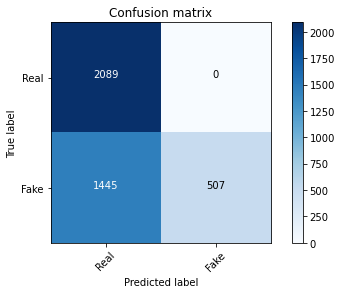

In [24]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Real', 'Fake'])

### PassiveAggressive Classifier

In [25]:
from sklearn.linear_model import PassiveAggressiveClassifier

pipe = Pipeline([('vect', CountVectorizer(analyzer=lambda x: x)),
                 ('tfidf', TfidfTransformer()),
                 ('model', PassiveAggressiveClassifier(max_iter=50))])

pac_model = pipe.fit(X_train, y_train)

y_pred = pac_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.91      1.00      0.95      2089
        Fake       1.00      0.89      0.94      1952

    accuracy                           0.95      4041
   macro avg       0.95      0.94      0.95      4041
weighted avg       0.95      0.95      0.95      4041



Confusion matrix, without normalization


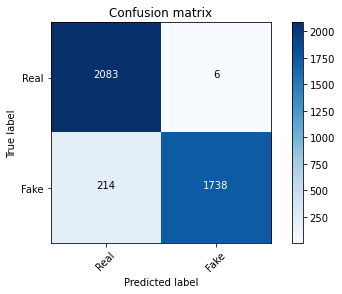

In [26]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Real', 'Fake'])

### Save Best Model

In [27]:
import dill

with open(f'{os.path.dirname(os.getcwd())}/src/models/fake_news/model.pkl', 'wb') as fptr:
    dill.dump(nb_model, fptr)